# Modeling

In this notebook we
1. Load '../Data/data_eda.csv' which is the output of exploratory data analysis.
2. Apply different model to predict Airbnb listing price.

**TODO: Add more features/model & add summary**

### Import Packages

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
sns.set_style("whitegrid")
palette = sns.diverging_palette(220, 20, sep = 20, n = 8)
sns.set_palette(palette)

### Load Data

In [2]:
df = pd.read_csv('../Data/data_eda.csv')
df.head()

,price,neighbourhood_cleansed,zipcode,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,guests_included,cancellation_policy,cleaning_fee,latitude_longitude_bin,neighbourhood_cleansed_reverted,shapes,accommodates_bedroom_ratio,accommodates_bathroom_ratio
0,85.0,81,14,0,0,4,1.0,1.0,1.0,4,2,1,61.710904,4,West Queen Anne,"Poly((9278.77, 24876.6) ...)",4.0,4.000000
1,150.0,81,14,0,0,4,1.0,1.0,1.0,4,1,2,40.000000,4,West Queen Anne,"Poly((9278.77, 24876.6) ...)",4.0,4.000000
2,975.0,81,14,9,0,11,4.5,5.0,7.0,4,10,2,300.000000,4,West Queen Anne,"Poly((9278.77, 24876.6) ...)",2.2,2.444444
3,100.0,81,14,0,0,3,1.0,0.0,2.0,4,1,0,61.710904,4,West Queen Anne,"Poly((9278.77, 24876.6) ...)",6.0,3.000000
4,450.0,81,14,9,0,6,2.0,3.0,3.0,4,6,2,125.000000,4,West Queen Anne,"Poly((9278.77, 24876.6) ...)",2.0,3.000000


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3818 entries, 0 to 3817
Data columns (total 18 columns):
price                              3818 non-null float64
neighbourhood_cleansed             3818 non-null int64
zipcode                            3818 non-null int64
property_type                      3818 non-null int64
room_type                          3818 non-null int64
accommodates                       3818 non-null int64
bathrooms                          3818 non-null float64
bedrooms                           3818 non-null float64
beds                               3818 non-null float64
bed_type                           3818 non-null int64
guests_included                    3818 non-null int64
cancellation_policy                3818 non-null int64
cleaning_fee                       3818 non-null float64
latitude_longitude_bin             3818 non-null int64
neighbourhood_cleansed_reverted    3818 non-null object
shapes                             3818 non-null object
a

In the data we have 17 features, 1 target. Total 3818 data points.

### Prepare functions for Plotting

In [4]:
def get_sub_plots(n_total_cols, n_cols, label_font_size = 14, tick_font_size = 13):
    n_rows = int(n_total_cols / n_cols)
    if n_total_cols % n_cols != 0:
        n_rows += 1

    fig, axes = plt.subplots(nrows = n_rows,
                             ncols = n_cols,
                             squeeze = False)
    
    fig.set_size_inches(20, 5)  
    
    if n_total_cols % n_cols != 0:
        for col in range(n_total_cols % n_cols, n_cols):
            fig.delaxes(axes[n_rows - 1][col])

    axes = axes.flatten()
    
    for ax in axes:
        ax.tick_params(labelsize = tick_font_size)
        ax.set_xlabel(ax.get_xlabel(), fontsize = label_font_size)
        ax.set_ylabel(ax.get_ylabel(), fontsize = label_font_size)

    return (fig, axes)

### Explore Data & Engineer Features

Engineer categorical data:

In [5]:
df_property_type_onehot = pd.get_dummies(df['property_type'], prefix = 'property_type')
df_property_type_onehot.head()

,property_type_0,property_type_1,property_type_2,property_type_3,property_type_4,property_type_5,property_type_6,property_type_7,property_type_8,property_type_9,property_type_10,property_type_11,property_type_12,property_type_13,property_type_14,property_type_15,property_type_16
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [6]:
df_neighbourhood_cleansed_onehot = pd.get_dummies(df['neighbourhood_cleansed'], prefix = 'neighbourhood_cleansed')
df_neighbourhood_cleansed_onehot.head()

,neighbourhood_cleansed_0,neighbourhood_cleansed_1,neighbourhood_cleansed_2,neighbourhood_cleansed_3,neighbourhood_cleansed_4,neighbourhood_cleansed_5,neighbourhood_cleansed_6,neighbourhood_cleansed_7,neighbourhood_cleansed_8,neighbourhood_cleansed_9,...,neighbourhood_cleansed_77,neighbourhood_cleansed_78,neighbourhood_cleansed_79,neighbourhood_cleansed_80,neighbourhood_cleansed_81,neighbourhood_cleansed_82,neighbourhood_cleansed_83,neighbourhood_cleansed_84,neighbourhood_cleansed_85,neighbourhood_cleansed_86
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


Check the price distribution with and without taking log.

In [7]:
def plot_ori_vs_log_comparison(x, xlabel, n_total_cols = 2, n_cols = 2, fontsize = 15):
    fig, axes = get_sub_plots(n_total_cols, n_cols)
    style = dict(size = fontsize, color = 'gray')
    
    x = pd.Series(x, name = xlabel)
    log_x = pd.Series(np.log(x), name = 'Taking log on ' + xlabel)

    sns.distplot(x, kde = False, ax = axes[0])
    axes[0].text(600, 550, 'Skew = ' + str(x.skew()), **style)
    axes[0].set_title('Histogram of ' + xlabel, fontsize = fontsize)
    axes[0].set_xlabel(xlabel, fontsize = fontsize)
    axes[0].set_ylabel('Count', fontsize = fontsize)

    sns.distplot(log_x, kde = False, ax = axes[1])
    axes[1].text(5.5, 280, 'Skew = ' + str(log_x.skew()), **style)
    axes[1].set_title('Histogram of ' + xlabel + ' with Log', fontsize = fontsize)
    axes[1].set_xlabel(xlabel + ' with Log', fontsize = fontsize)
    axes[1].set_ylabel('Count', fontsize = fontsize)
    
    fig.tight_layout()    
    plt.show()

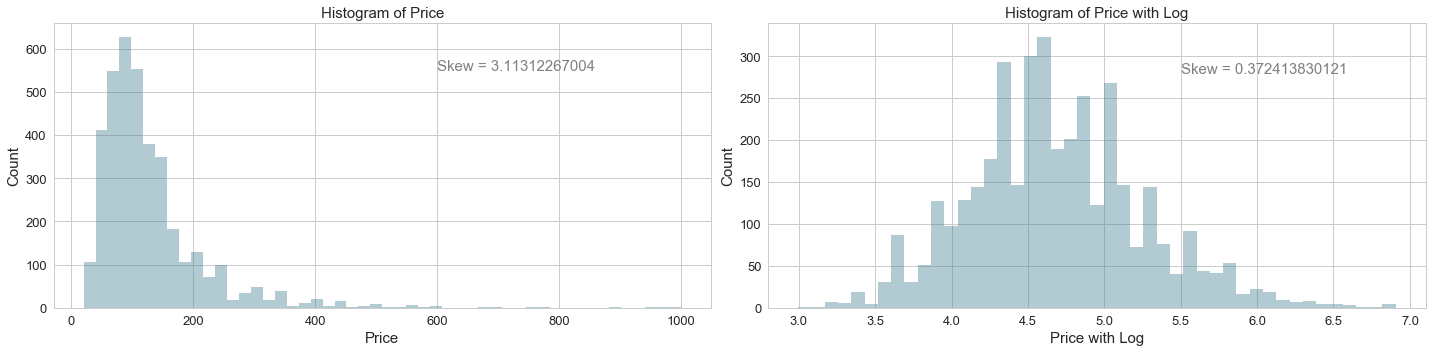

In [8]:
plot_ori_vs_log_comparison(df.price, 'Price')

Looks like taking log can make it distribute more normally & skew is much improved.

### Prepare functions for Scoring & Reporting

Here we use mean squared error for scoring.

We also plot
1. Histogram of predited y.
2. Scatter plot of Actual vs. Predicted y
3. Residual plot

In [9]:
from sklearn.metrics import mean_squared_error

def plot_summary(y_test, y_pred, n_total_cols = 3, n_cols = 3, fontsize = 15):
    fig, axes = get_sub_plots(n_total_cols, n_cols)
    
    sns.distplot(y_pred, kde = False, ax = axes[0])
    axes[0].set_title('Histogram of predicted y', fontsize = fontsize)
    axes[0].set_xlabel('Pridected y', fontsize = fontsize)
    axes[0].set_ylabel('Count', fontsize = fontsize)

    sns.regplot(y_test, y_pred, fit_reg = False, ax = axes[1])
    axes[1].set_title('Actual y vs. Predicted y', fontsize = fontsize)
    axes[1].set_xlabel('Actual y', fontsize = fontsize)
    axes[1].set_ylabel('Predicted y', fontsize = fontsize)
    
    sns.regplot(y_pred, y_test - y_pred, fit_reg = False, ax = axes[2])
    axes[2].set_title('Residual Plot', fontsize = fontsize)
    axes[2].set_xlabel('Predicted y', fontsize = fontsize)
    axes[2].set_ylabel('Residuals', fontsize = fontsize)
    
    fig.tight_layout()    
    plt.show()
    
def score_and_plot(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** (1/2)
    
    print ('    MSE is: ', mse)
    print ('    RMSE is: ', rmse)

    plot_summary(y_test, y_pred)

### Prepare functions for Modeling

#### We will try the following models:
1. K-Nearest Neighbors
2. Linear Regression
3. Ridge Regression
4. Lasso Regression
5. Random Forest

#### Train-Test-Split, Cross-Validation & Standardization
We also use train_test_split to do train-test split, GridSearchCV to do cross-validation & use StandardScaler to standardize the data.

BTW as in previous plot we can see that taking log can make the target distribute more normally, we add one more argument, take log (or not), to check if it can give better results.

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor

Models = ['KNN', 'Linear', 'Ridge', 'Lasso', 'RandomForest']

def model(model_mode, X, y, take_log):
    if model_mode not in Models:
        print('Mode not defined')
        return
    
    if take_log:
        y = np.log(y)

    steps = [('scaler', StandardScaler())]
    
    if model_mode == 'KNN':
        steps += [('knn', KNeighborsRegressor())]
        param_grid = {'knn__n_neighbors': np.arange(1, 50)}
    elif model_mode == 'Linear':
        steps += [('lm', LinearRegression())]  
        param_grid = {}          
    elif model_mode == 'Ridge':
        steps += [('ridge', Ridge())]
        param_grid = {'ridge__alpha': [0.0000001, 0.000001, 0.00001, 0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}          
    elif model_mode == 'Lasso':
        steps = [('lasso', Lasso(max_iter = 10000))]
        param_grid = {'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]}          
    elif model_mode == 'RandomForest':
        steps = [('rf', RandomForestRegressor(random_state = 42))]
        param_grid = {'rf__n_estimators': np.arange(10, 100, 10),
                      'rf__max_depth' : np.arange(10, 100, 10)}
    
    pipeline = Pipeline(steps)
          
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = .33)
          
    cv = GridSearchCV(pipeline, param_grid, cv = 5)
    cv.fit(X_train, y_train)
          
    print('Model:', model_mode)
    if take_log:
        print('    Taking log on y')
    else:
        print('    NOT taking log on y')
    print('    Best Params:', cv.best_params_)

    y_pred = cv.predict(X_test)
    
    if take_log:
        score_and_plot(np.exp(y_test), np.exp(y_pred))
    else:
        score_and_plot(y_test, y_pred)

### Define Features & Target

Let's start with the most basic features: accommodates, bathrooms, bedrooms & property type.

In [11]:
df_X = pd.concat([df[['accommodates', 'bathrooms', 'bedrooms']], df_property_type_onehot], axis = 1)

X = df_X.as_matrix()
y = df['price'].as_matrix()

Model: KNN
    NOT taking log on y
    Best Params: {'knn__n_neighbors': 11}
    MSE is:  4187.71814902
    RMSE is:  64.7125810722


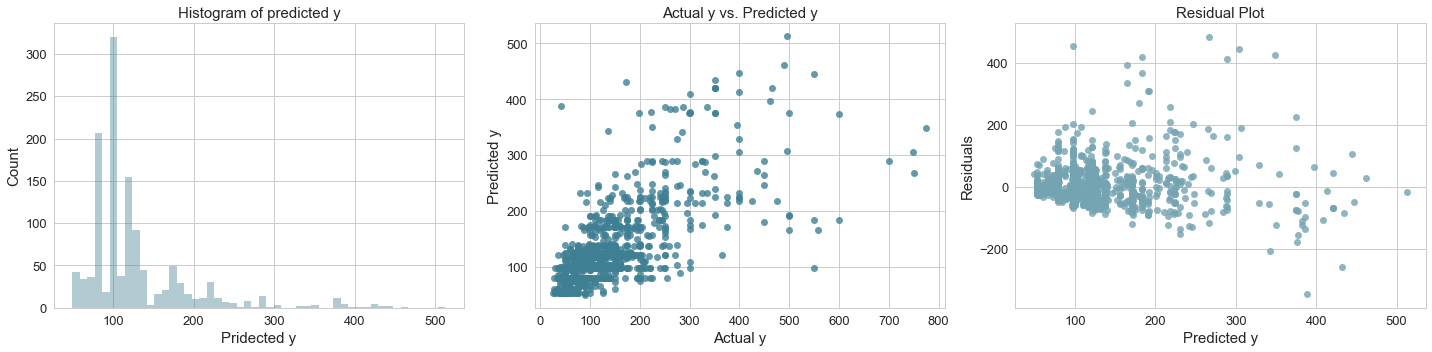

Model: Linear
    NOT taking log on y
    Best Params: {}
    MSE is:  4105.37813032
    RMSE is:  64.0732247536


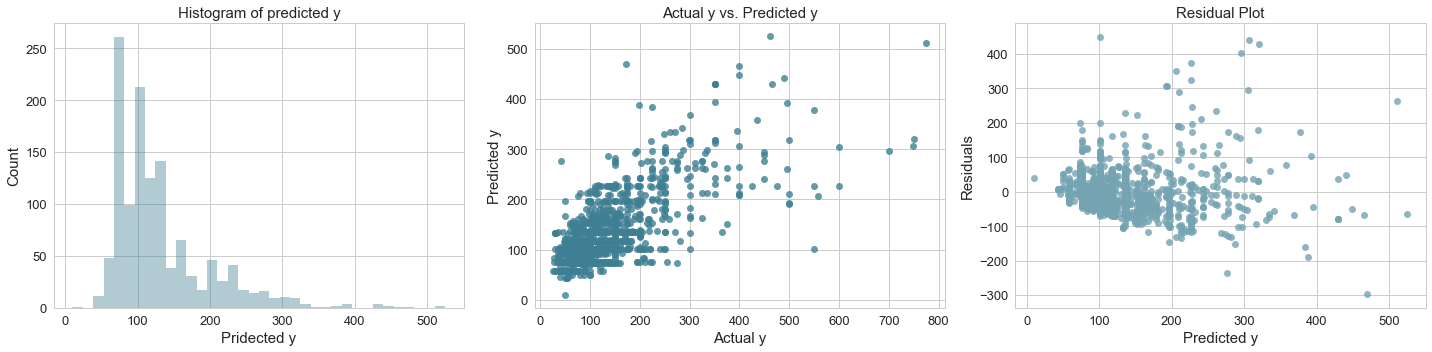

Model: Linear
    Taking log on y
    Best Params: {}
    MSE is:  6017.87035212
    RMSE is:  77.5749337874


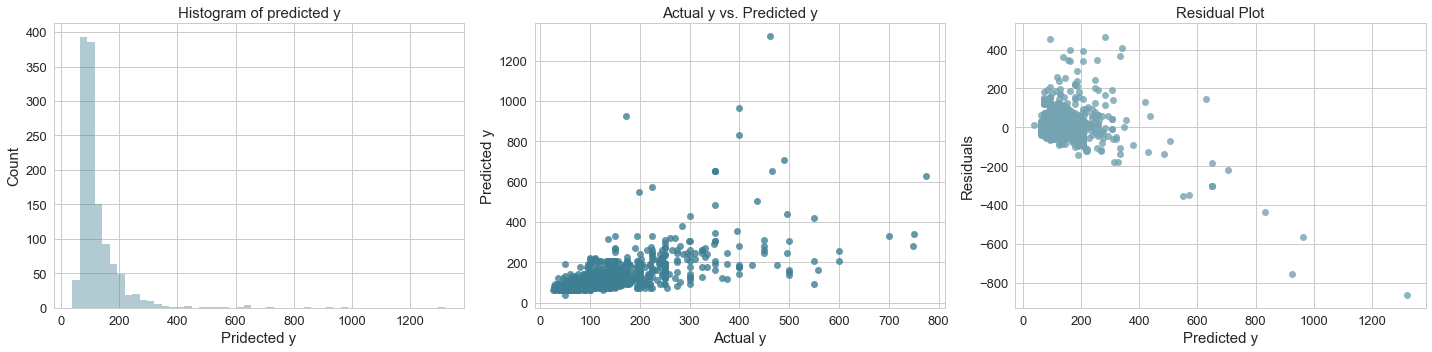

Model: Ridge
    NOT taking log on y
    Best Params: {'ridge__alpha': 100}
    MSE is:  4097.65403234
    RMSE is:  64.0129208233


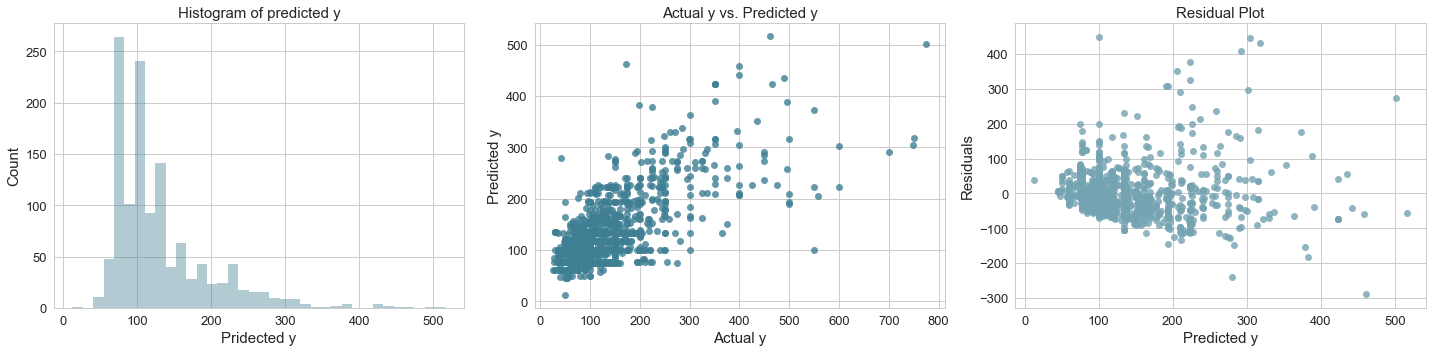

Model: Ridge
    Taking log on y
    Best Params: {'ridge__alpha': 50}
    MSE is:  5831.6618992
    RMSE is:  76.3653186937


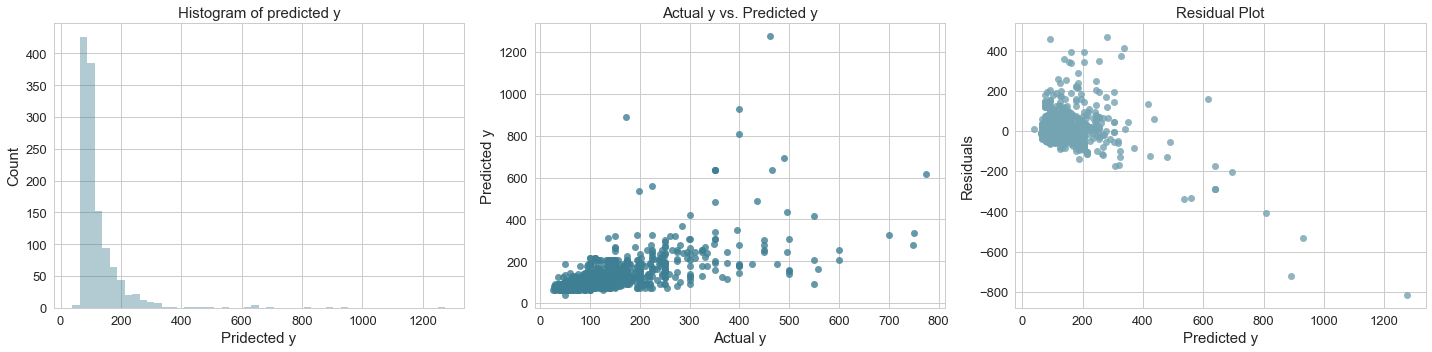

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of

Model: Lasso
    NOT taking log on y
    Best Params: {'lasso__alpha': 0.1}
    MSE is:  4165.01548502
    RMSE is:  64.5369311714


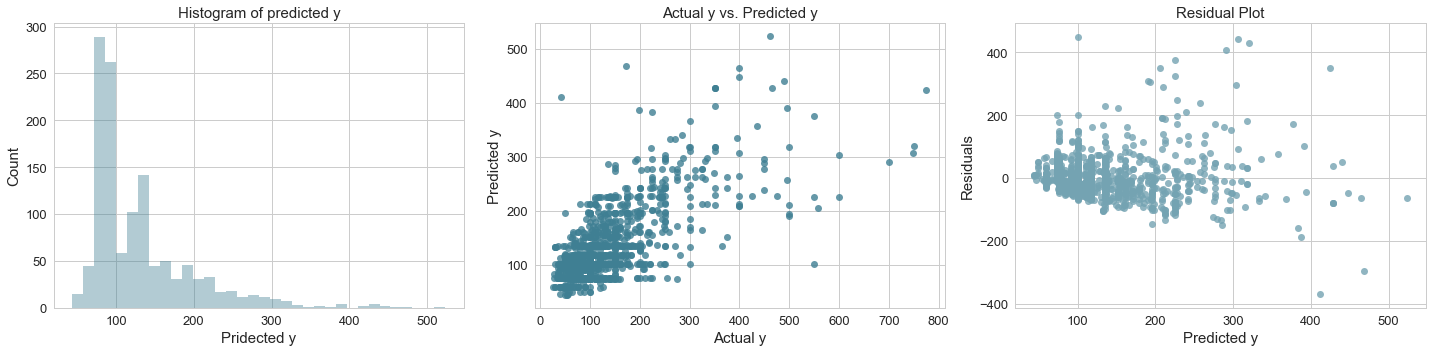

Model: Lasso
    Taking log on y
    Best Params: {'lasso__alpha': 0.001}
    MSE is:  6157.04886265
    RMSE is:  78.4668647434


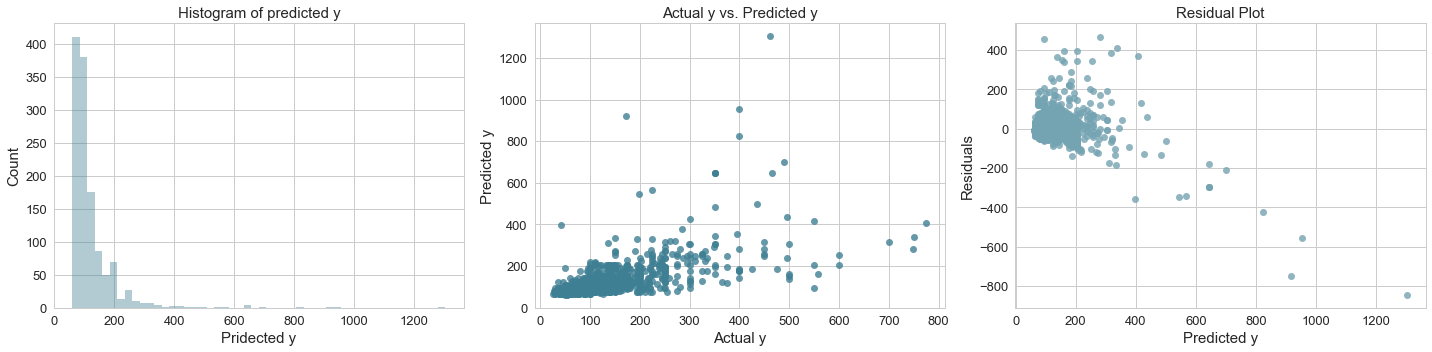

Model: RandomForest
    NOT taking log on y
    Best Params: {'rf__max_depth': 10, 'rf__n_estimators': 20}
    MSE is:  4084.82072683
    RMSE is:  63.9126022536


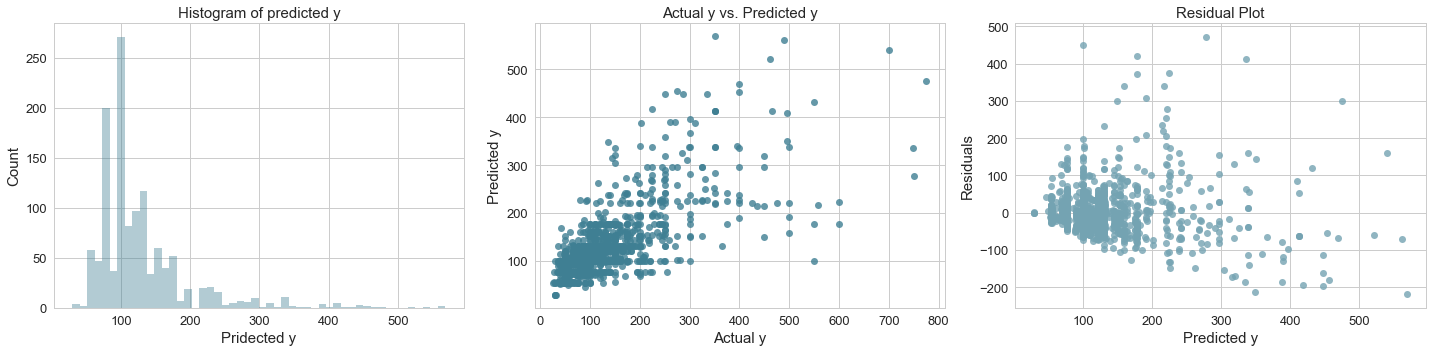

In [12]:
for m in Models:
    model(m, X, y, take_log = False)
    
    if m in ['Linear', 'Ridge', 'Lasso']:
        model(m, X, y, take_log = True)